In [1]:
%matplotlib inline
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
import util
from model import NetMain

In [2]:
path = "DATA/IR VIS HAK/"

imgs_rgb, imgs_ir = util.loadDataset(path, "images_rgb_filtered", "images_ir_filtered")

In [3]:
print(imgs_rgb.shape)
imgs_ir.shape

(12633, 240, 320)


(12633, 240, 320)

In [4]:
vol_size = imgs_rgb.shape[1:]
model = NetMain(vol_size)
model.load_state_dict(torch.load("NetMainFilteredv3_3.pt"))
model.eval()

NetMain(
  (unet_model): Unet(
    (enc): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (dec): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [5]:
imRGB = util.parseImages(imgs_rgb, 1280)
imIR = util.parseImages(imgs_ir, 1280)
imRGB.shape

torch.Size([1280, 1, 240, 320])

C:\Users\lucaw\Anaconda3\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


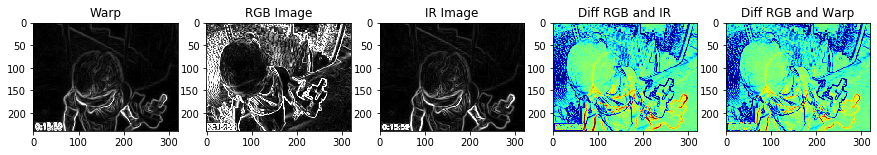

In [6]:
#warp, flow = model(imIR[None, 0], imRGB[None, 0])
util.printResult(*util.getImagesById2(imRGB, imIR, 251, model))

In [7]:
def gradient_loss(s, penalty='l2'):
    dy = torch.abs(s[:, :, 1:, :] - s[:, :, :-1, :]) 
    dx = torch.abs(s[:, :, :, 1:] - s[:, :, :, :-1]) 

    if(penalty == 'l2'):
        dy = dy * dy
        dx = dx * dx

    d = torch.mean(dx) + torch.mean(dy)
    return d / 2.0

In [8]:
mini_batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(e, fixed_input, moving_input, mini_batch_size):
    model.train()
    sum_loss = 0
    criterion = nn.MSELoss()
    for b in range(0, fixed_input.size(0), mini_batch_size):
        
        optimizer.zero_grad()
        warp, flow = model(moving_input.narrow(0, b, mini_batch_size), fixed_input.narrow(0, b, mini_batch_size))
        
        recon_loss = criterion(warp, fixed_input.narrow(0, b, mini_batch_size))
        #recon_loss = F.nll_loss(warp, fixed_input.narrow(0, b, mini_batch_size))
        grad_loss = gradient_loss(flow)
        loss = recon_loss + 0.6 * grad_loss # 0.05 for model1 and model2
        sum_loss = sum_loss + loss.item()
        
        loss.backward()
        optimizer.step()

    print(e, sum_loss, loss, recon_loss, grad_loss)

In [17]:
for epoch in range(1, 11):
    train(epoch, imRGB, imIR, mini_batch_size)

1 7.583874851465225 tensor(0.1227, grad_fn=<AddBackward0>) tensor(0.1202, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
2 7.581646889448166 tensor(0.1227, grad_fn=<AddBackward0>) tensor(0.1201, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
3 7.57951932400465 tensor(0.1227, grad_fn=<AddBackward0>) tensor(0.1201, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
4 7.577492460608482 tensor(0.1226, grad_fn=<AddBackward0>) tensor(0.1201, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
5 7.57567585259676 tensor(0.1226, grad_fn=<AddBackward0>) tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
6 7.573861181735992 tensor(0.1226, grad_fn=<AddBackward0>) tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<DivBackward0>)
7 7.572102405130863 tensor(0.1226, grad_fn=<AddBackward0>) tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<DivBackward0>)
8 7.570399269461632 te

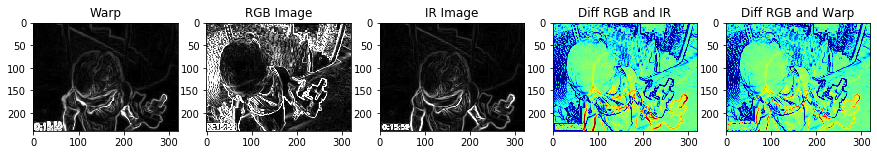

In [18]:
util.printResult(*util.getImagesById2(imRGB, imIR, 251, model))

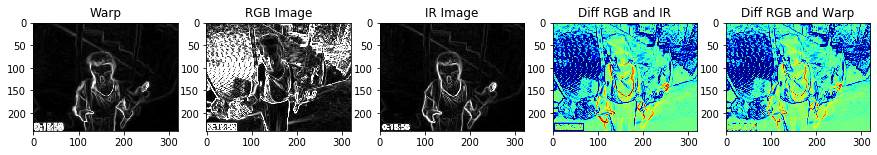

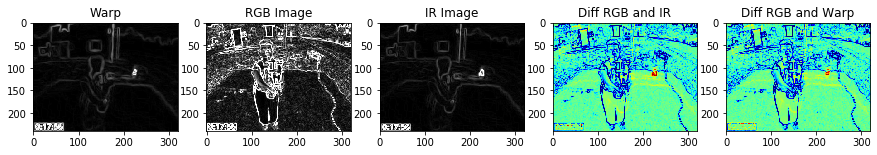

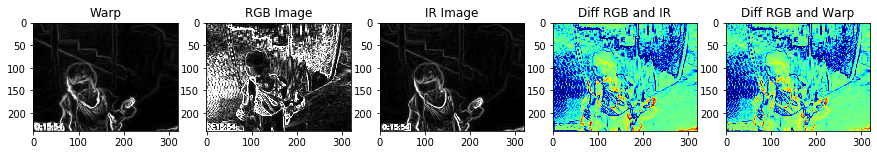

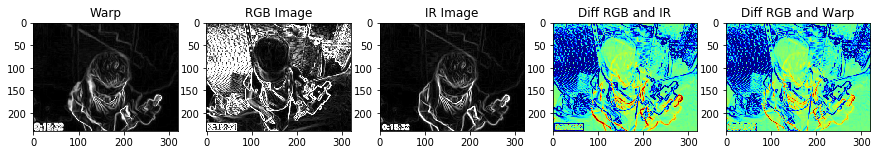

In [19]:
util.printResult(*util.getImagesById2(imRGB, imIR, 742, model))
util.printResult(*util.getImagesById2(imRGB, imIR, 1230, model))
util.printResult(*util.getImagesById2(imRGB, imIR, 210, model))
util.printResult(*util.getImagesById2(imRGB, imIR, 530, model))

(2, 240, 320)


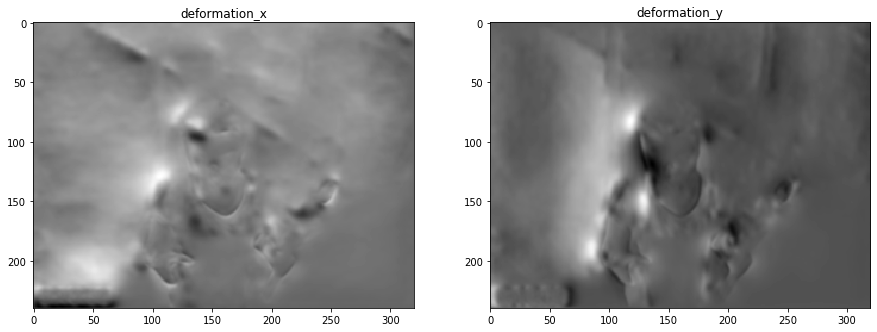

In [20]:
warp, flow = model(imIR[None, 742], imRGB[None, 742])
plt.figure(figsize=(15, 15))
flow = flow[0, ...].detach().numpy()
flowx = flow[0, ...]
flowy = flow[1, ...]
plt.subplot(121)
plt.title("deformation_x")
plt.imshow(flowx, cmap='gray')
print(flow.shape)
plt.subplot(122)
plt.title("deformation_y")
plt.imshow(flowy, cmap='gray')

In [21]:
torch.save(model.state_dict(), "NetMainFilteredv3_4.pt")